# Anomaly Detection in Python

#### Spot Anomalies in Your Data Analysis
Extreme values or anomalies are present in almost any dataset, and it is critical to detect and deal with them before continuing statistical exploration. When left untouched, anomalies can easily disrupt our analyses and skew the performance of machine learning models.

#### Learn to Use Estimators Like Isolation Forest and Local Outlier Factor
In this course, we'll leverage Python to implement a variety of anomaly detection methods. We'll spot extreme values visually and use tested statistical techniques like Median Absolute Deviation for univariate datasets. For multivariate data, we'll learn to use estimators such as Isolation Forest, k-Nearest-Neighbors, and Local Outlier Factor. We'll also learn how to ensemble multiple outlier classifiers into a low-risk final estimator. We'll walk away with an essential data science tool in our belt: anomaly detection with Python.

#### Expand Your Python Statistical Toolkit
Better anomaly detection means better understanding of our data, and particularly, better root cause analysis and communication around system behaviour. Adding this skill to our existing Python repertoire will help us with data cleaning, fraud detection, and identifying system disturbances.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from scipy.stats import zscore
from scipy.spatial.distance import euclidean


from pyod.models.mad import MAD
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF


from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

## Detecting Univariate Outliers

This chapter covers techniques to detect outliers in 1-dimensional data using histograms, scatterplots, box plots, z-scores, and modified z-scores.

#### What are anomalies and outliers?

One of the quickest methods for getting a feel for new data is the 5-number summary. It prints out 5 metrics about a distribution - the minimum, 25th percentile, median, 75th percentile, and the maximum along with mean and standard deviation. By looking at the 5-number summary and the difference between the mean and the minimum/maximum values, we can get a rough idea of whether outliers are present in the distribution.

In the exercises of this chapter, we will be using the metrics about a distribution of the data to detect the prices of the most expensive (or inexpensive) [NY Airbnb listings](http://insideairbnb.com/get-the-data).

In [2]:
airbnb_df = pd.read_csv("data/ny_listings.csv")
airbnb_df = airbnb_df[['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price']]
airbnb_df['price'] = pd.to_numeric(airbnb_df['price'].str.replace('[^\d.]', ''), errors='coerce')

print(airbnb_df.shape)
airbnb_df.head()

(43566, 6)


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_21180\3686116167.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  airbnb_df['price'] = pd.to_numeric(airbnb_df['price'].str.replace('[^\d.]', ''), errors='coerce')


,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,30,49,0.30,3,325,240.0
1,30,50,0.29,2,0,60.0
2,5,22,0.14,1,268,120.0
3,21,3,0.03,1,275,276.0
4,30,35,0.30,1,160,315.0


In [3]:
# Extract price
prices = airbnb_df['price']

# Print 5-number summary
print(prices.describe())

count    43566.000000
mean       225.216109
std        818.738268
min          0.000000
25%         80.000000
50%        136.000000
75%        228.000000
max      90120.000000
Name: price, dtype: float64


A histogram can be a compelling visual for finding outliers. They can become apparent when an appropriate number of bins is chosen for the histogram. Recall that the square root of the number of observations can be used as a rule of thumb for setting the number of bins. Usually, the bins with the lowest heights will contain outliers.

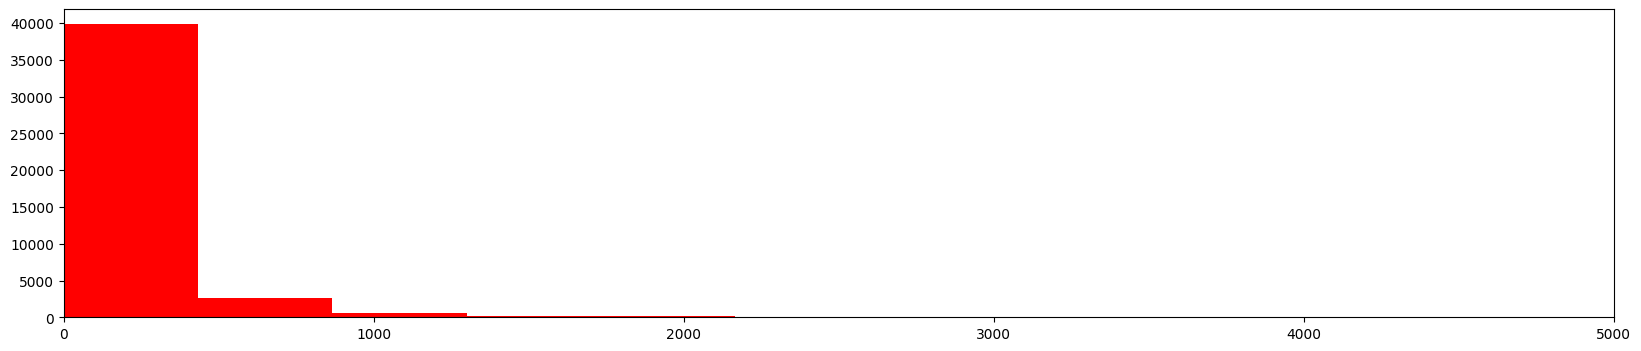

In [4]:
# Find the square root of the length of prices
n_bins = np.sqrt(len(prices))

# Cast to an integer
n_bins = int(n_bins)

plt.figure(figsize=(20, 4))

# Create a histogram
plt.hist(prices, bins=n_bins, color='red')
plt.xlim([0, 5000])
plt.show()

Notice the low bars from ~500 to ~1000 in the x-axis. Also, even though they are not visible, there must be some bars with almost 0 height to the far right of the histogram. Otherwise, it wouldn't be this wide.

A scatterplot is another handy method to identify outliers visually. Although it is usually used to plot two variables against each other to inspect their relationship, using some trick we can plot a scatterplot with only one variable to make the outliers stand out.

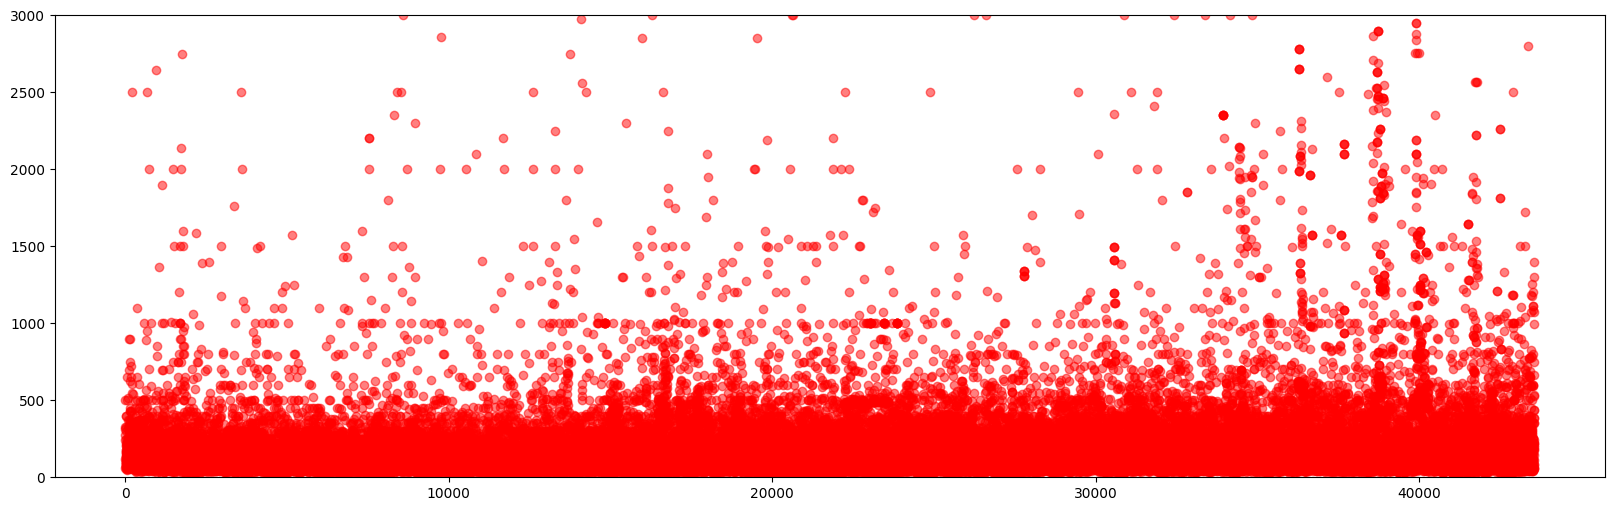

In [5]:
# Create a list of consecutive integers
integers = range(len(prices))

plt.figure(figsize=(20, 6))

# Plot a scatterplot
plt.scatter(integers, prices, c='red', alpha=0.5)
plt.ylim([0, 3000])
plt.show()

Notice how we can draw similar conclusions from the scatterplot. Like in the histogram, the cloud of dots become much sparser as we go up from the 500-1000 mark in the y-axis.

#### Box plots and IQR

In this exercise, we will get a feel of what the NY Airbnb Listings prices data looks like using boxplots. This will enable us to assess the range of the distribution where inliers lie. We will also get a sense of custom versus default parameters for setting whisker lengths to classify outliers.

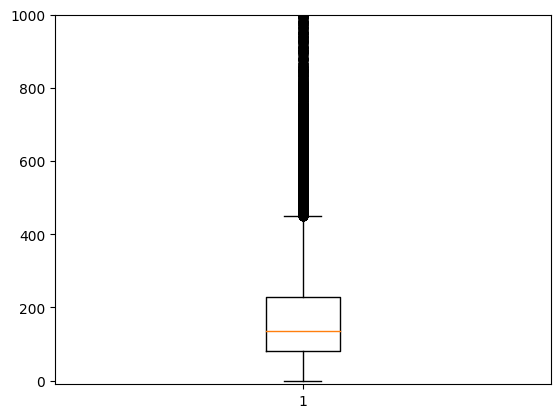

In [6]:
# Create a boxplot of prices
plt.boxplot(prices)
plt.ylim([-10, 1000])
plt.show()

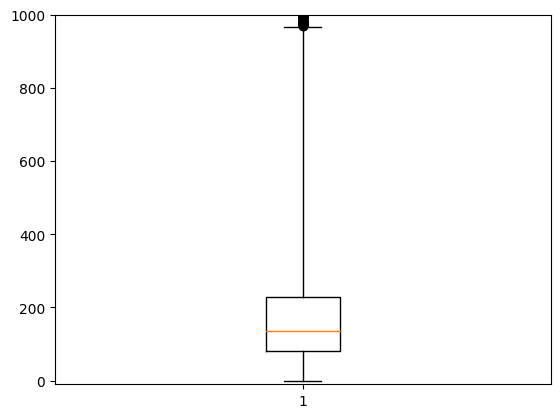

In [7]:
# Create a boxplot with custom whisker lengths
plt.boxplot(prices, whis=5)
plt.ylim([-10, 1000])
plt.show()

Since the magnitude of the outliers in the distribution is higher than normal datapoints, the boxplots are squished into the bottom. But, we could make the whiskers longer by using a larger multiplying factor.

Visualizing outliers is usually only the first step in detecting outliers. To go beyond visualizing outliers, we will need to write code that isolates the outliers from the distribution.

In this exercise, we will implement the first step of what's going on under the hood of the boxplot. In other words, we will calculate the lower and upper outlier limits manually.

In [8]:
# Calculate the 25th and 75th percentiles
q1 = prices.quantile(0.25)
q3 = prices.quantile(0.75)

# Find the IQR
IQR = q3 - q1
factor = 2.5

# Calculate the lower limit
lower_limit = q1 - factor*IQR

# Calculate the upper limit
upper_limit = q3 + factor*IQR

Now that we have our limits, let's actually use them to filter the outliers! We will use for categorizing outliers. In this exercise, we'll apply them to the prices distribution to isolate the outliers.

In [9]:
# Create a mask for values lower than lower_limit
is_lower = prices < lower_limit

# Create a mask for values higher than upper_limit
is_higher = prices > upper_limit

# Combine the masks to filter for outliers
outliers = prices[is_lower | is_higher]

# Count and print the number of outliers
print("Out of {}, {} are outliers.".format(len(prices), len(outliers)))

Out of 43566, 2004 are outliers.


Using IQR and a factor of 5, we found 2004  outliers out of 40k observations.

#### Using z-scores for Anomaly Detection

The normal distribution is ubiquitous in the natural world and is the most common distribution. This is why the z-score method can be one of the quickest methods for detecting outliers.

Recall the rule of thumb: if a sample is more than __three__ standard away deviations from the mean, we can consider it an extreme value.

However, recall also that the z-score method should be approached with caution. This method is appropriate only when we are confident our data comes from a normal distribution. Otherwise, the results might be misleading.

In [10]:
# Find the zscores of prices
scores = zscore(prices)

# Check if the absolute values of scores are over 3
is_over_3 = np.abs(scores) > 3

# Use the mask to subset prices
outliers = prices[is_over_3]

print(len(outliers))

152


We found 152 outliers from sales, but we found over 2k in the last exercise. This means we might have had some mislabeled data points in the last exercise because the prices distribution is not normally distributed.

It is time to unleash `pyod` on outliers. We use the `MAD` estimator from `pyod` to utilize modified z-scores. The `MAD` estimator uses the `median_abs_deviation` function under the hood.

In [11]:
# Initialize with a threshold of 3.5
mad = MAD(threshold=3.5)

# Reshape prices to make it 2D
prices_reshaped = prices.values.reshape(-1, 1)

# Fit and predict outlier labels on prices_reshaped
labels = mad.fit_predict(prices_reshaped)

# Filter for outliers
outliers = prices_reshaped[labels == 1]

print(len(outliers))

3200


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


We've added two powerful algorithms to our univariate outlier detection arsenal. Use z-scores when you have a normal distribution. If you doubt the distribution of your data, turn to modified z-scores with MAD.

## Isolation Forests with PyOD

In this chapter, we’ll learn the ins and outs of how the Isolation Forest algorithm works. Explore how Isolation Trees are built, the essential parameters of PyOD's IForest and how to tune them, and how to interpret the output of IForest using outlier probability scores.

#### Getting started with Isolation Forests

`IForest` is a robust estimator and only requires a few lines of code to detect outliers from any dataset. We may find that this syntax looks familiar since it closely resembles `sklearn` syntax.

For this exercise we are going to use the [Big Mart Sales data](https://www.kaggle.com/datasets/brijbhushannanda1979/bigmart-sales-data?resource=download).

We will start with data cleaning and preparations.

In [12]:
big_mart = pd.read_csv("data/big_mart.csv")
big_mart.columns
# ['weight', 'max_retail_price', 'sales', 'fat_content', 'type']
big_mart = big_mart[['Item_Weight', 'Item_MRP', 'Item_Outlet_Sales', 'Item_Fat_Content', 'Item_Type']]
big_mart.rename(columns = {'Item_Weight':'weight', 
                           'Item_MRP':'max_retail_price',
                           'Item_Outlet_Sales':'sales', 
                           'Item_Fat_Content':'fat_content',
                           'Item_Type':'type',
                          }, 
                inplace = True)
big_mart.head()

,weight,max_retail_price,sales,fat_content,type
0,9.30,249.8092,3735.1380,Low Fat,Dairy
1,5.92,48.2692,443.4228,Regular,Soft Drinks
2,17.50,141.6180,2097.2700,Low Fat,Meat
3,19.20,182.0950,732.3800,Regular,Fruits and Vegetables
4,8.93,53.8614,994.7052,Low Fat,Household


In [13]:
big_mart.apply(lambda x: sum(x.isnull()))

weight              1463
max_retail_price       0
sales                  0
fat_content            0
type                   0
dtype: int64

In [14]:
big_mart.dropna(inplace=True)
big_mart.apply(lambda x: len(x.unique()))

weight               415
max_retail_price    5225
sales               3066
fat_content            5
type                  16
dtype: int64

In [15]:
# check out the frequecy of each different category in each nomical value

# filter the categorical variables
categorical_columns = [x for x in big_mart.dtypes.index if big_mart.dtypes[x]=='object']


# print the frequency of categories
for col in categorical_columns:
    big_mart[col] = big_mart[col].str.lower()
    print('\nFrequency of Categories for variable %s'%(col))
    print(big_mart[col].value_counts())


Frequency of Categories for variable fat_content
low fat    4306
regular    2388
lf          260
reg         106
Name: fat_content, dtype: int64

Frequency of Categories for variable type
fruits and vegetables    1019
snack foods               988
household                 759
frozen foods              718
dairy                     566
canned                    539
baking goods              536
health and hygiene        430
soft drinks               374
meat                      337
breads                    204
hard drinks               183
others                    137
starchy foods             130
breakfast                  89
seafood                    51
Name: type, dtype: int64


In [16]:
big_mart['fat_content'] = big_mart['fat_content'].replace({'LF': 'low fat', 
                                                           'reg': 'regular'})
big_mart['fat_content'].head(5)

0    low fat
1    regular
2    low fat
3    regular
4    low fat
Name: fat_content, dtype: object

In [17]:
# Create music_dummies
big_mart_dummies = pd.get_dummies(big_mart, drop_first=True)

big_mart_dummies.head()

,weight,max_retail_price,sales,fat_content_low fat,fat_content_regular,type_breads,type_breakfast,type_canned,type_dairy,type_frozen foods,type_fruits and vegetables,type_hard drinks,type_health and hygiene,type_household,type_meat,type_others,type_seafood,type_snack foods,type_soft drinks,type_starchy foods
0,9.30,249.8092,3735.1380,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,5.92,48.2692,443.4228,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,17.50,141.6180,2097.2700,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,19.20,182.0950,732.3800,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,8.93,53.8614,994.7052,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [18]:
# Initialize an instance with default parameters
iforest = IForest()

# Generate outlier labels
labels = iforest.fit_predict(big_mart_dummies)

# Filter big_mart for outliers
outliers = big_mart_dummies[labels == 1]


# Count and print the number of outliers
print("Out of {}, {} are outliers.".format(len(big_mart_dummies), len(outliers)))

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


Out of 7060, 706 are outliers.


#### Overview of Isolation Forest hyperparameters

Even though the code implementation only takes a few lines, finding the suitable contamination requires attention.

Recall that `contamination` parameter only affects the results of `IForst`. Once `IForest` generates raw anomaly scores, `contamination` is used to chose the top `n%` of anomaly scores as outliers. For example, 5% contamination will choose the observations with the highest 5% of anomaly scores as outliers.

In [19]:
# Instantiate an instance with 5% contamination
iforest = IForest(contamination=0.05)

# Fit IForest to Big Mart sales data
iforest.fit_predict(big_mart_dummies)

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


array([0, 1, 0, ..., 0, 0, 0])

If we load someone else's already trained `IForest` instance and want to see its contamination, we can print its `contamination` attribute.

`n_estimators` is the parameter that influences model performance the most. Building `IForest` with enough trees ensures that the algorithm has enough generalization power to isolate the outliers from normal data points. The optimal number of trees depends on dataset size, and any number that is too high or too low will lead to inaccurate predictions.

In [20]:
# Create an IForest with 300 trees
iforest = IForest(n_estimators=300)

# Fit to the Big Mart sales data
iforest.fit_predict(big_mart_dummies)

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


array([0, 1, 0, ..., 0, 0, 0])

Note that we still don't know if 300 trees were enough for our problem. We can't know whether chosen hyperparameters are effective until we combine the outlier classifier with a supervised learning model. To check if `IForest` performs better or worse on a dataset, we have to combine it with models such as Linear Regression and check its performance using the current `IForest` parameters.

#### Hyperparameter tuning of Isolation Forest

Finally, it is time to tune the notorious `contamination` parameter. For that, we will use the `evaluate_outlier_classifier` and `evaluate_regressor` functions.

We will be using a sample of the NY Airbnb Listings dataset.

In [21]:
airbnb_df.dropna(inplace=True)
airbnb_sample_df = airbnb_df[:2000].copy()

In [22]:
def evaluate_outlier_classifier(model, data):
    # Get labels
    labels = model.fit_predict(data)

    # Return inliers
    return data[labels == 0]



def evaluate_regressor(inliers):
    X = inliers.drop("price", axis=1)
    y = inliers[['price']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    preds = lr.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return round(rmse, 3)

In [23]:
contaminations = [0.07, 0.1, 0.15, 0.25]
scores = dict()

for c in contaminations:
    # Instantiate IForest with the current c
    iforest = IForest(contamination=c, random_state=10)
    
    # Get inliers with the current IForest
    inliers = evaluate_outlier_classifier(iforest, airbnb_sample_df)
    
    # Calculate and store RMSE into scores
    scores[c] = evaluate_regressor(inliers)
    
print(scores)

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


{0.07: 112.605, 0.1: 107.92, 0.15: 91.112, 0.25: 87.725}


From this console output, we can see that 25% contamination is the best.

In this exercise, we will practice tuning multiple hyperparameters simultaneously. This is a valuable topic to learn, as hyperparameters of an algorithm usually affect each other's values. Therefore, tuning them individually is not usually the recommended course of action.

We will tune the `max_features` and `max_samples` parameters of `IForest`.

In [24]:
max_features = [0.6, 0.8, 1]
max_samples = [0.6, 0.8, 1]
scores = dict()

for mf, ms in product(max_features, max_samples):
    # Instantiate an IForest
    iforest = IForest(max_features=mf, max_samples=ms, n_jobs=-1, contamination=.25, random_state=1)
    
    # Get the inliers with the current IForest
    inliers = evaluate_outlier_classifier(iforest, airbnb_sample_df)
    
    # Calculate and store RMSE into scores
    scores[(mf, ms)] = evaluate_regressor(inliers)
    
print(scores)

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


{(0.6, 0.6): 83.495, (0.6, 0.8): 88.602, (0.6, 1): 202.303, (0.8, 0.6): 88.409, (0.8, 0.8): 78.607, (0.8, 1): 202.303, (1, 0.6): 138.731, (1, 0.8): 133.237, (1, 1): 202.303}


We can see from the output that 0.8 `max_features` and 0.8 `max_samples` give the lowest score. Now, we are prepared to tune the hyperparameters of any outlier classifier we will learn next.

#### Interpreting the output of IForest

Until now, we have been using the `.fit_predict()` method to fit `IForest` and generate predictions simultaneously. However, `pyod` documentation suggests using the fit function first and accessing the inlier/outlier `labels_` via a handy attribute.

We will practice this on the `big_mart_dummies` dataset.

In [25]:
iforest = IForest(n_estimators=200)

# Fit (only fit) it to the Big Mart sales
iforest.fit(big_mart_dummies)

# Access the labels_ for the data
labels = iforest.labels_

# Filter outliers from big_mart
outliers = big_mart_dummies[labels == 1]

print(len(outliers))

706


An alternative to isolating outliers with `contamination` is using outlier probabilities. The best thing about this method is that we can choose an arbitrary probability threshold, which means we can be as confident as we want in the predictions.

In [26]:
iforest = IForest(random_state=10).fit(big_mart_dummies)

# Calculate probabilities
probs = iforest.predict_proba(big_mart_dummies)

# Extract the probabilities for outliers
outlier_probs = probs[:, 1]

# Filter for when the probability is higher than 70%
outliers = big_mart[outlier_probs >= 0.7]

print(len(outliers))

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


395


## Distance and Density-based Algorithms

After a tree-based outlier classifier, we will explore a class of distance and density-based detectors. KNN and Local Outlier Factor classifiers have been proven highly effective in this area, and we will learn how to use them.

#### KNN for outlier detection

We will practice `KNN` for the first time on a version of the [Ansur Body Measurements dataset for females](https://www.openlab.psu.edu/ansur2/).

In [27]:
females = pd.read_csv('data\ANSUR_II_FEMALE_Public.csv')
col_to_drop = ['Branch', 'Component', 'DODRace', 'Date', 'Ethnicity', 'Gender', 'Installation', 
               'PrimaryMOS', 'SubjectId', 'SubjectNumericRace', 'SubjectsBirthLocation', 
               'Weightlbs', 'WritingPreference']
females = females.drop(columns = col_to_drop, axis=1)
# females.info()

In [28]:
# Instantiate KNN and fit to females
knn = KNN(contamination=0.005, n_neighbors=20, n_jobs=-1)
knn.fit(females)

# Create a boolean index that checks for outliers
is_outlier = knn.labels_ == 1

# Isolate the outliers
outliers = females[is_outlier]

print(len(outliers))

10


We used a 0.5% contamination level in this exercise, which returned only 10 outliers. This aligns well with our assumption that soldiers in the army are usually fit, so the vast majority doesn't have anomalous measurements.

Since we cannot wholly trust the output when using `contamination`, let's double-check our work using outlier probabilities. They are more trustworthy.

In [29]:
# Instantiate a KNN with 20 neighbors and fit to `females`
knn = KNN(n_neighbors=20)
knn.fit(females)

# Calculate probabilities
probs = knn.predict_proba(females)

# Create a boolean mask
is_outlier = probs[:,1] > 0.55

# Use the boolean mask to filter the outliers
outliers = females[is_outlier]

print(len(outliers))

11


It seems like our choice of contamination in the last exercise was almost spot-on because the probability filtering method returned nearly the same number of outliers as the contamination method.

#### Outlier-robust feature scaling

Euclidean distance is the most popular distance metric in statistics. Its popularity mainly comes from the fact that it is intuitive to understand. It is the Pythagorean theorem applied in Cartesian coordinates. We will start with a manual practice calculating it with NumPy.

In [30]:
M = np.array([14, 17, 18, 20, 14, 12, 19, 13, 17, 20])
N = np.array([63, 74, 76, 72, 64, 75, 75, 61, 50, 53])

# Subtract M from N and square the result
squared_diffs = (M - N) ** 2

# Calculate the sum
sum_diffs = sum(squared_diffs)

# Find the square root
dist_MN = np.sqrt(sum_diffs)

print(dist_MN)

160.63934760823702


We don't have to repeat this whole process every time. In the next exercises, we will practice an already defined function that does all this.

Instead of writing multiple lines of code to calculate the euclidean distance, we can use SciPy. The library not only contains the `euclidean` function, but more than 40 other distance metrics—all a single import statement away.

In [31]:
# Use the euclidean function on M and N
dist_MN = euclidean(M,N)

print(dist_MN)

160.63934760823702


It is dangerous to use `KNN` on unknown distributions blindly. Its performance suffers greatly when the feature distributions don't have the same scales. Unscaled features will skew distance calculations and thus return unrealistic anomaly scores.

A common technique to counter this is using standardization, which involves removing the mean from a feature and dividing it by the standard deviation. This has the effect of making the feature have a mean of 0 and a variance of 1.

In [32]:
# Initialize a StandardScaler
ss = StandardScaler()

# Extract feature and target arrays
X = females.drop('weightkg', axis=1) 
y = females['weightkg']

# Fit/transform X
X_transformed = ss.fit_transform(X)

# Fit/transform X but preserve the column names
X.loc[:,:] = ss.fit_transform(X)

`StandardScaler` is a great choice for features that follow a normal distribution and with very few outliers.

Standardization is prone to the same pitfalls as z-scores. Both use mean and standardization in their calculations, which makes them highly sensitive to extreme values.

To get around this problem, we should use `QuantileTransformer` which uses quantiles. Quantiles of a distribution stay the same regardless of the magnitude of outliers.

We should use `StandardScaler` when the data is normally distributed (which can be checked with a histogram). For other distributions, `QuantileTransformer` is a better choice.

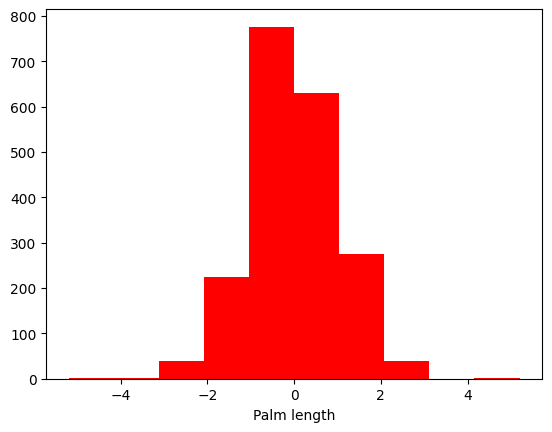

In [33]:
# Instantiate an instance that casts to normal
qt = QuantileTransformer(output_distribution="normal")

# Fit and transform the feature array
X.loc[:,:] = qt.fit_transform(X)

# Plot a histogram of palm length
plt.hist(X['palmlength'], color='red')

plt.xlabel("Palm length")
plt.show()

The bell-shaped histogram shows that `QuantileTransformer` worked as expected.

#### Hyperparameters of KNN

It is crucial to capture the subtle differences between the manhattan, euclidean and Minkowski distance metrics. Using them correctly ensures the optimal performance of outlier classifiers on various datasets.

Remember from the formula that changing the parameter `p` will switch between euclidean, manhattan and other degrees of the Minkowski distance. Since distance-based algorithms are popular in machine learning, knowing a few distance metrics well will go a long way.


<img src="minkowski_distance.png" width="500px">



While euclidean distance is very popular, it only scales well beyond two or three-dimensional data. In these cases, we can use manhattan distance as an alternative. It has the advantage of working exceptionally well with datasets with many categorical features.

In [34]:
M = np.array([14, 17, 18, 20, 14, 12, 19, 13, 17, 20])
N = np.array([63, 74, 76, 72, 64, 75, 75, 61, 50, 53])

# Subtract M from N and find the absolute value
abs_diffs = np.abs(N - M)

# Calculate the final manhattan distance
manhattan_dist_MN = sum(abs_diffs)

print(manhattan_dist_MN)

499


`n_neighbors` is the most crucial parameter of KNN. When we are unsure about the number of outliers in the dataset (which happens often), we can't use the rule of thumb that suggests using 20 neighbors when contamination is below 10%. For such cases, we'll have to tune `n_neighbors`. For this practice, we will use the transformed version of the `females` dataset from the last exercise, `females_transformed`. 

In [35]:
females_transformed = females.copy()

# Instantiate an instance that casts to normal
# ss = StandardScaler()
qt = QuantileTransformer(output_distribution="normal")

# Fit and transform the feature array
females_transformed.loc[:,:] = qt.fit_transform(females_transformed)
# females_transformed.loc[:,:] = ss.fit_transform(females_transformed)
females_transformed.head()

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Age,Heightin
0,0.142244,-0.935852,-0.631785,-0.769761,-1.084195,-0.493553,-0.493553,0.422483,0.397918,-0.458426,...,-0.076604,-0.020074,0.248427,-0.388430,-0.769761,-0.123259,-0.334851,-0.995858,-0.095492,-1.349498
1,-1.181921,0.766391,0.514923,-0.565738,0.949547,-0.239380,-0.384375,0.374936,-1.111702,-1.059682,...,-1.513589,-1.664082,-1.716415,-1.095556,1.029375,-1.391202,0.113152,0.577557,-0.985610,-0.162552
2,-1.684464,0.595437,1.046576,1.152175,0.583496,0.771450,1.411293,1.710968,-0.116941,0.146048,...,-0.945616,-1.442543,-2.365248,0.535083,1.086456,-0.055229,0.908975,0.147316,-0.556927,1.225943
3,0.963423,0.392492,-0.290058,-0.048948,0.232930,1.035790,0.622621,1.029375,1.733071,0.146048,...,0.133379,0.661162,0.749670,0.691121,0.396560,0.981540,2.225823,0.644086,-0.749670,0.523537
4,2.289988,-0.577557,-0.149853,-0.048948,-0.523537,-0.941700,0.015055,0.708752,0.552537,2.483413,...,2.875333,2.727515,2.325972,1.029375,-1.431971,1.732614,-0.334851,-0.840906,1.684464,-0.558392


In [36]:
def evaluate_outlier_classifier(model, data, threshold=.75):
    model.fit(data)

    probs = model.predict_proba(data)
    inliers = data[probs[:, 1] <= threshold]

    return inliers

def evaluate_regressor(inliers):
    X, y = inliers.drop("weightkg", axis=1), inliers[['weightkg']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, train_size=0.8)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    preds = lr.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return round(rmse, 3)

In [37]:
# Create a list of values for n_neigbors
n_neighbors = [5, 10, 20]
scores = dict()

for k in n_neighbors:
    # Instantiate KNN with the current k
    knn = KNN(n_neighbors=k, n_jobs=-1)
    
    # Find the inliers with the current KNN
    inliers = evaluate_outlier_classifier(knn, females_transformed, .50)
    
    # Calculate and store RMSE into scores
    scores[k] = evaluate_regressor(inliers)
    
print(scores)

{5: 0.093, 10: 0.09, 20: 0.09}


From the output, we see that 10 and 20 neighbors return the lowest RMSE score.

Once the optimal number of neighbors is found, it's time to tune the distance aggregating method. If `n_neighbors` is 10, each datapoint will have ten distance measurements to its nearest neighbors. KNN uses three methods to aggregate those distances: `largest`, `mean`, and `median`. Let's find out which is best for the `females_transformed` dataset.

In [38]:
n_neighbors = [5, 20]
methods = ['largest', 'mean', 'median']
scores = dict()

for k, m in product(n_neighbors, methods):
    # Create a KNN instance
    knn = KNN(n_neighbors=k, method=m, n_jobs=-1)
    
    # Find the inliers with the current KNN
    inliers = evaluate_outlier_classifier(knn, females_transformed, 0.5)

    # Calculate and store RMSE into scores
    scores[(k, m)] = evaluate_regressor(inliers)
    
print(scores)

{(5, 'largest'): 0.093, (5, 'mean'): 0.095, (5, 'median'): 0.092, (20, 'largest'): 0.09, (20, 'mean'): 0.096, (20, 'median'): 0.093}


From the output, we can see that 10 neighbors and `largest` distance aggregation method returns the lowest RMSE score.

#### Local Outlier Factor

`LOF` differs from `KNN` only in the internal algorithm and the lack of the method parameter. Practice detecting outliers with it using contamination filtering on the scaled version of females dataset.

In [39]:
# Instantiate LOF and fit to females_transformed
lof = LOF(contamination=0.003, n_neighbors=20, n_jobs=-1)
lof.fit(females_transformed)

# Create a boolean index that checks for outliers
is_outlier = lof.labels_ == 1

# Isolate the outliers
outliers = females_transformed[is_outlier]

print(len(outliers))

6


`LOF` with contamination filtering of 0.3% finds only six outliers. Let's see how accurate that is.

As always, let's double-check that the chosen contamination level is trustworthy by filtering the outliers with a probability threshold. The syntax is the same as with `KNN`.

In [40]:
# Instantiate an LOF with 20 neighbors and fit to the data
lof = LOF(n_neighbors=20, n_jobs=-1)
lof.fit(females_transformed)

# Calculate probabilities
probs = lof.predict_proba(females_transformed)

# Create a boolean mask
is_outlier = probs[:,1] > 0.5

# Use the boolean mask to filter the outliers
outliers = females_transformed[is_outlier]

print(len(outliers))

11


0.3% contamination (six outliers) was indeed a close guess. We found four outliers using probability filtering.



## Time Series Anomaly Detection and Outlier Ensembles

In this chapter, we’ll learn how to perform anomaly detection on time series datasets and make our predictions more stable and trustworthy using outlier ensembles. For this, we are going to use the [Apple stocks dataset](https://assets.datacamp.com/production/repositories/2168/datasets/3748d04d5afec762dab8d26dee3844c0f8f8f540/AAPL.csv).

In [52]:
apple = pd.read_csv('data/AAPL.csv')
apple.head()

,Date,Open,High,Low,Close,Volume
0,04/10/2011,374.57,381.80,354.2400,372.50,44059900
1,05/10/2011,367.86,379.82,360.3000,378.25,28088200
2,06/10/2011,373.33,384.78,371.8045,377.37,29020800
3,07/10/2011,375.78,377.74,368.4890,369.80,19123500
4,10/10/2011,379.09,388.81,378.2100,388.81,15804100


#### Introduction to time series

In [53]:
# Convert the Date column to DateTime
apple['Date'] = pd.to_datetime(apple['Date'], dayfirst=True)

# Create a column for the day of the week
apple['day_of_week'] = apple['Date'].dt.day_of_week

# Create a column for the month
apple['month'] = apple['Date'].dt.month

# Create a column for the day of the month
apple['day_of_month'] = apple['Date'].dt.day

print(apple[['day_of_week', 'month', 'day_of_month']])

      day_of_week  month  day_of_month
0               1     10             4
1               2     10             5
2               3     10             6
3               4     10             7
4               0     10            10
...           ...    ...           ...
1588            4      1            26
1589            0      1            29
1590            1      1            30
1591            2      1            31
1592            3      2             1

[1593 rows x 3 columns]


Now, we can convert date components of time series into DateTime columns and extract useful features from them.

Having a `DatetimeIndex` is helpful for several reasons. First, we can use brackets notation to choose arbitrary time periods or write only a line of code to create line plots.

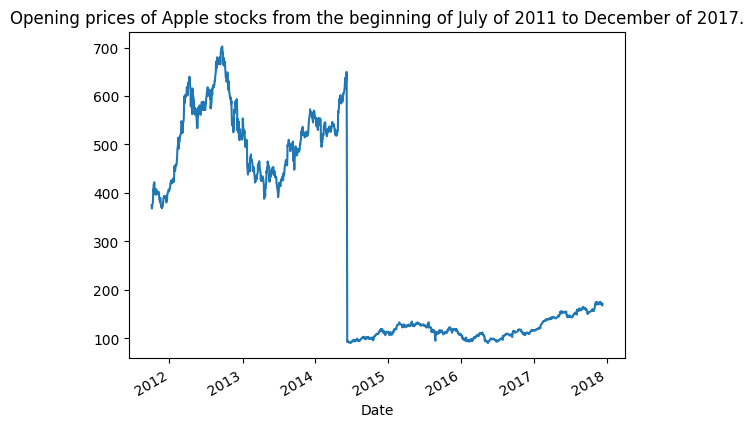

In [58]:
# Set the Date column as a DatetimeIndex
apple.set_index('Date', inplace=True)

# Plot the opening prices for the instructed range
apple.loc["2011-07":"2017-12-09", 'Open'].plot()

plt.title("Opening prices of Apple stocks from the beginning of July of 2011 to December of 2017.")
plt.show()

Now, we can use pandas `DatetimeIndex` to choose date ranges and plot them in a single line.

Initially, we can approach time series anomaly detection just like a regular dataset. For example, we can take a univariate approach and fit `MAD` to one of the time series columns.

In [61]:
# Load the Apple stocks dataset with a proper DatatimeIndex
apple = pd.read_csv("data/AAPL.csv", parse_dates=["Date"], dayfirst=True, index_col="Date")

# Fit MAD to the Volume column
mad = MAD().fit(apple[['Volume']])

# Isolate the outliers
is_outlier = mad.labels_ == 1
outliers = apple[is_outlier]

print(len(outliers))

32


We find 64 outliers using a univariate approach with the `Volume` column.

If we want to use all the information available, we can fit a multivariate outlier detector to the entire dataset. The multivariate approach also enables us to extract more features from time series to enhance model performance.

Let's Practice creating new features from a `DatetimeIndex` and fitting an outlier detector on them using the `apple` dataset.

In [62]:
apple['day_of_week'] = apple.index.day_of_week
apple['month'] = apple.index.month
apple['day_of_month'] = apple.index.day

# Create and fit an IForest
iforest = IForest(random_state=1).fit(apple)

# Generate outlier probabilities
probs = iforest.predict_proba(apple)

# Isolate the outliers
is_outlier = probs[:,1] >= 0.7
outliers = apple[is_outlier]

print(len(outliers))

99


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


Notice that `IForest` finds fewer outliers. Again, this might be because `IForest` discovered new patterns in the data due to the addition of three new features and the rest of the columns.

#### Time Series Decomposition for Outlier Detection

Decomposition will be an essential part of our toolbox when working with time series. In this exercise, we will practice seasonal decomposition.

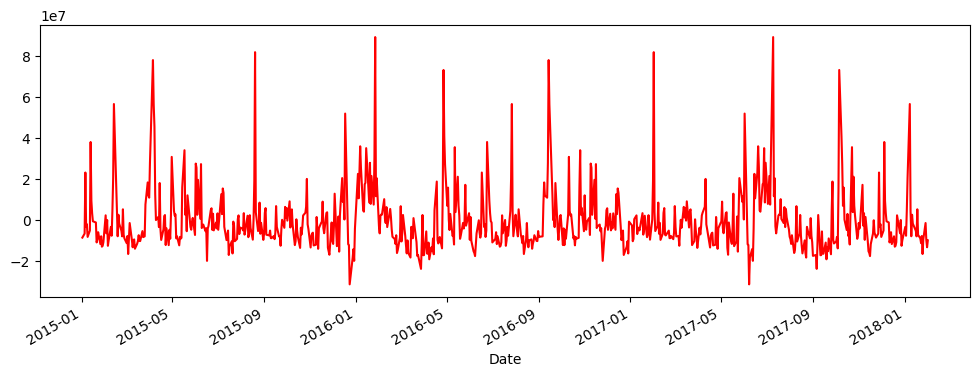

In [66]:
# Create a DecomposeResult object and plot seasonality
results = seasonal_decompose(apple.loc["2015":"2018","Volume"], period=365)
results.seasonal.plot(color="red", figsize=(12, 4))

plt.show()

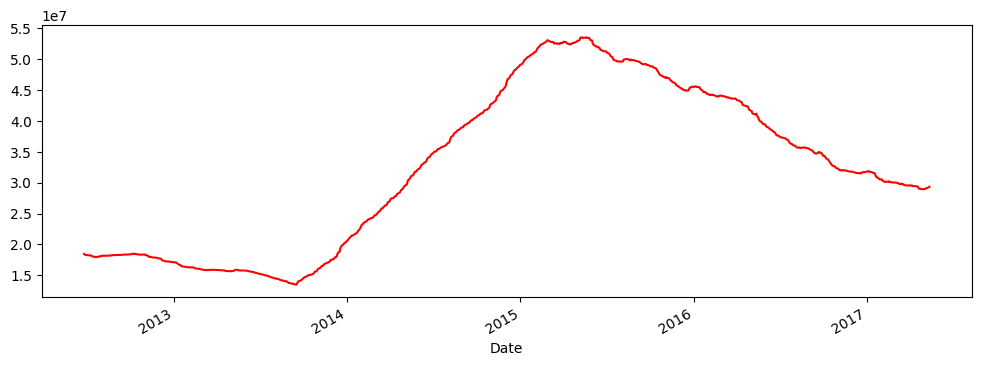

In [69]:
# Create a DecomposeResult object and plot trend
results = seasonal_decompose(apple['Volume'], period=365)

results.trend.plot(color="red", figsize=(12, 4))

plt.show()

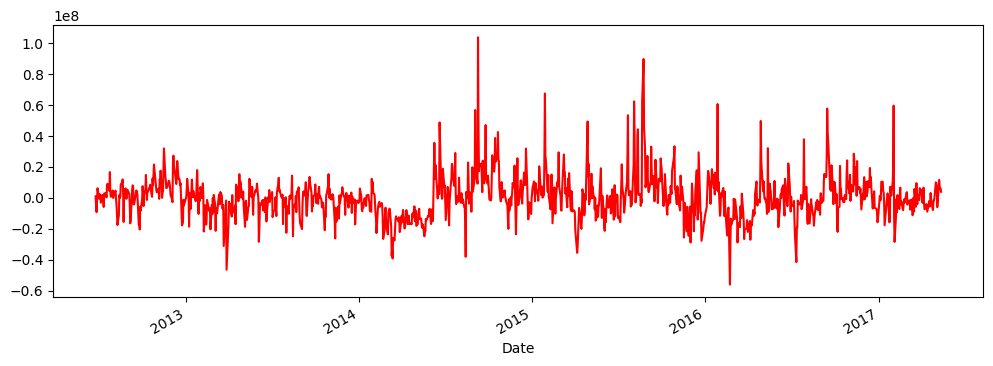

In [70]:
# Create a DecomposeResult object and plot residuals
results.resid.plot(color="red", figsize=(12, 4))

plt.show()

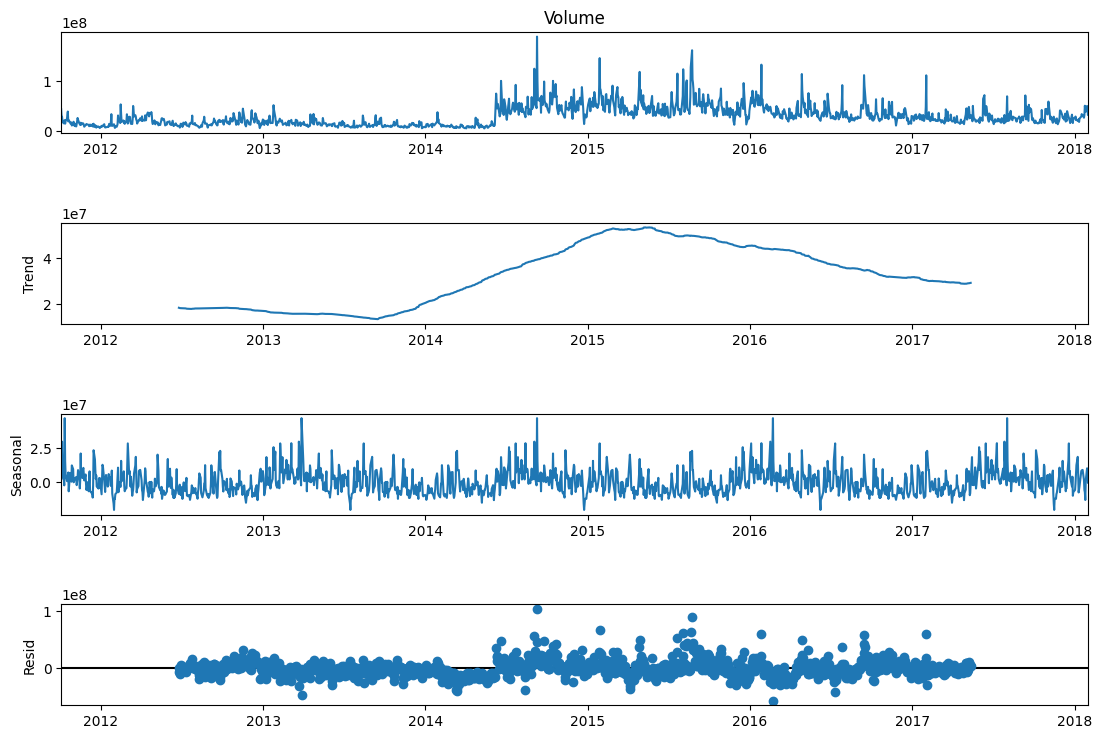

In [71]:
results = seasonal_decompose(apple['Volume'], period=365)

# Plot all three components
fig = results.plot()

fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

Now, we can break down any time series into seasonality, trend and residuals to find insights about the series not visible to the naked eye.

Another method of detecting outliers from time series is fitting a classifier to the residuals from decomposition. This is also a univariate approach with the advantage of being much faster than other multivariate methods.

In [72]:
results = seasonal_decompose(apple['Volume'], period=365)

residuals = results.resid
residuals = residuals.values.reshape(-1, 1)

mad = MAD().fit(residuals)

# Find the outliers
is_outlier = mad.labels_ == 1
outliers = apple[is_outlier]

print(len(outliers))

32


By fitting an outlier classifier to the residuals, we find 32 outliers, which was faster than using a multivariate classifier on the full dataset.

#### Outlier classifier ensembles

In this exercise, we will practice scaling only parts of a dataset. The reason for doing this is that the stocks datasets have numerically-encoded categorical features (`day_of_week`, `day`, `month`) that would have been incorrectly scaled if we used `QuantileTransformer` on the full dataset.

In [73]:
apple.head()

,Open,High,Low,Close,Volume,day_of_week,month,day_of_month
Date,,,,,,,,
2011-10-04,374.57,381.80,354.2400,372.50,44059900,1,10,4
2011-10-05,367.86,379.82,360.3000,378.25,28088200,2,10,5
2011-10-06,373.33,384.78,371.8045,377.37,29020800,3,10,6
2011-10-07,375.78,377.74,368.4890,369.80,19123500,4,10,7
2011-10-10,379.09,388.81,378.2100,388.81,15804100,0,10,10


In [74]:
# Create a list of columns
to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']

# Initialize a QuantileTransformer
qt = QuantileTransformer(output_distribution="normal")

# Scale and store simultaneously
apple.loc[:,to_scale] = qt.fit_transform(apple[to_scale])

Now, we can use this dataset while building outlier ensembles. 

An ensemble is a collection of one or more machine learning models combined to make their predictions more robust. Creating outlier ensembles manually usually takes practice. Therefore, we will perform the operation in three steps. In this exercise, we will create a list of estimators and an empty array to store the probability scores.

In [75]:
# Create a list of two IForest estimators
estimators = [IForest(n_estimators=50), IForest(n_estimators=100)]

# Create an empty array to store probabilities
shape = (len(apple), len(estimators))
probability_scores = np.empty(shape=shape)

In practice, we can increase the number of estimators in estimators as much as possible to make the final predictions even more robust. It is good practice to choose 2 or 3 instances with different parameters for each type of classifier we choose.

Continue building the ensemble by writing the code block that loops over `estimators` and generates outlier probabilities.

In [76]:
for index, est in enumerate(estimators):
    est.fit(apple)
    
    probs = est.predict_proba(apple)
    
    # Store into probability_scores
    probability_scores[:, index] = probs[:,1]

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


We have the probabilities from the estimators, and it is now time to average them. 

There are many aggregation methods available when using ensembles. The most popular ones are the arithmetic mean and median. We can use the mean almost always, while we can reserve the median for cases when we have at least three or more classifiers in our estimators.

In [77]:
# Find the mean across rows
mean_probs = np.mean(probability_scores, axis=1)

# Create a boolean mask that uses a 75% threshold
is_outlier = mean_probs > 0.75

# Use the mask to filter outliers from apple
outliers = apple[is_outlier]

print(len(outliers))

22


We find 22 outliers using an outlier ensemble. 

#### How to deal with identified outliers

Trimming a distribution is one of the easiest ways of dealing with an outlier without dropping it. If we know the natural range of values a distribution must take related to our business problem, we can use that knowledge to trim the distribution.

Or, if we have some previous knowledge about which specific values are considered outliers based on domain knowledge or experience, we can also replace them with hard-coded values.

In [78]:
percentile_first = apple['Volume'].quantile(0.01)
percentile_99th = apple['Volume'].quantile(0.99)

apple['Volume'] = apple['Volume'].clip(percentile_first, percentile_99th)

# Replace 0s with 100s
apple.replace(0, 100, inplace=True)

display(apple.head())

                Open      High       Low     Close    Volume  day_of_week  \
Date                                                                        
2011-10-04  0.208570  0.213235  0.198250  0.205323  0.805639            1   
2011-10-05  0.198258  0.210159  0.200111  0.215769  0.163069            2   
2011-10-06  0.206172  0.221077  0.211802  0.213555  0.203284            3   
2011-10-07  0.211062  0.205465  0.206197  0.202478 -0.392449            4   
2011-10-10  0.215670  0.228897  0.220560  0.234219 -0.613694          100   

            month  day_of_month  
Date                             
2011-10-04     10             4  
2011-10-05     10             5  
2011-10-06     10             6  
2011-10-07     10             7  
2011-10-10     10            10  
